In [2]:
# We need to install a wide variety of libraries. For this we will install pandas, numpy, seaborn and matplotlib libraries.

import numpy as np
import pandas as pd
import seaborn as sns
import string
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore")

# Graphics in retina format are more sharp and legible
%config InlineBackend.figure_format = 'retina'

## 1- Loading the data.

In [3]:
df = pd.read_csv("../input/sms-spam-collection-dataset/spam.csv", encoding="latin-1")

df = df.dropna(how="any", axis=1)
df.columns = ['target', 'message']

df.head()

,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## 2- Exploratory Data Analysis (EDA)

In [4]:
df.describe()

,target,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [5]:
df['message_n_chars'] = df.message.apply(len) # count all chars in each sentence
df['message_n_words'] = df.message.apply(lambda sent: len(sent.split())) # count number of words in each sentence
df.head()

,target,message,message_n_chars,message_n_words
0,ham,"Go until jurong point, crazy.. Available only ...",111,20
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28
3,ham,U dun say so early hor... U c already then say...,49,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13


In [6]:
max(df.message_n_chars), max(df.message_n_words)

(910, 171)

In [7]:
# Convert target to numerical variable
df['lable'] = df.target.map({'ham': 0,
                            'spam': 1})
df.head()

,target,message,message_n_chars,message_n_words,lable
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,0
1,ham,Ok lar... Joking wif u oni...,29,6,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,1
3,ham,U dun say so early hor... U c already then say...,49,11,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,0


In [8]:
df['target'].value_counts(normalize= True)

target
ham     0.865937
spam    0.134063
Name: proportion, dtype: float64

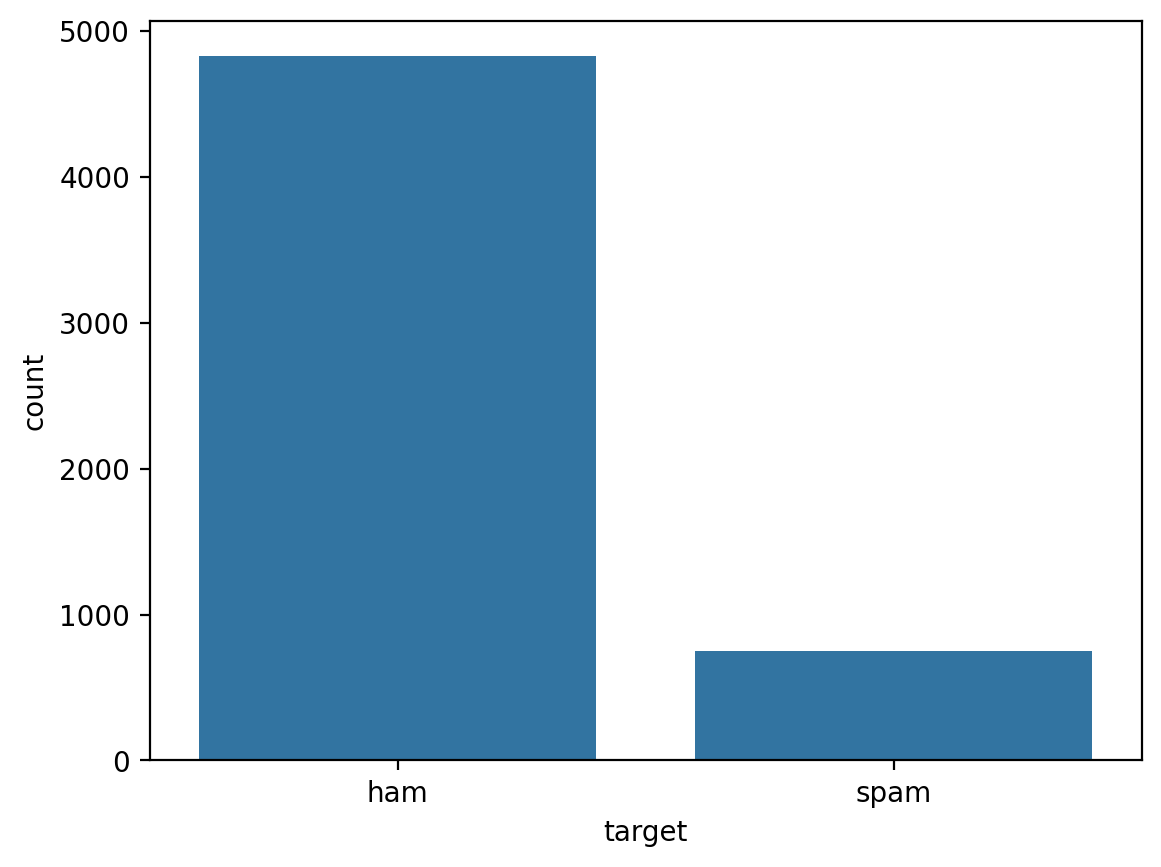

In [9]:
sns.countplot(data = df, x = 'target');

**The distribution of number of chars and number of words in each sentence**

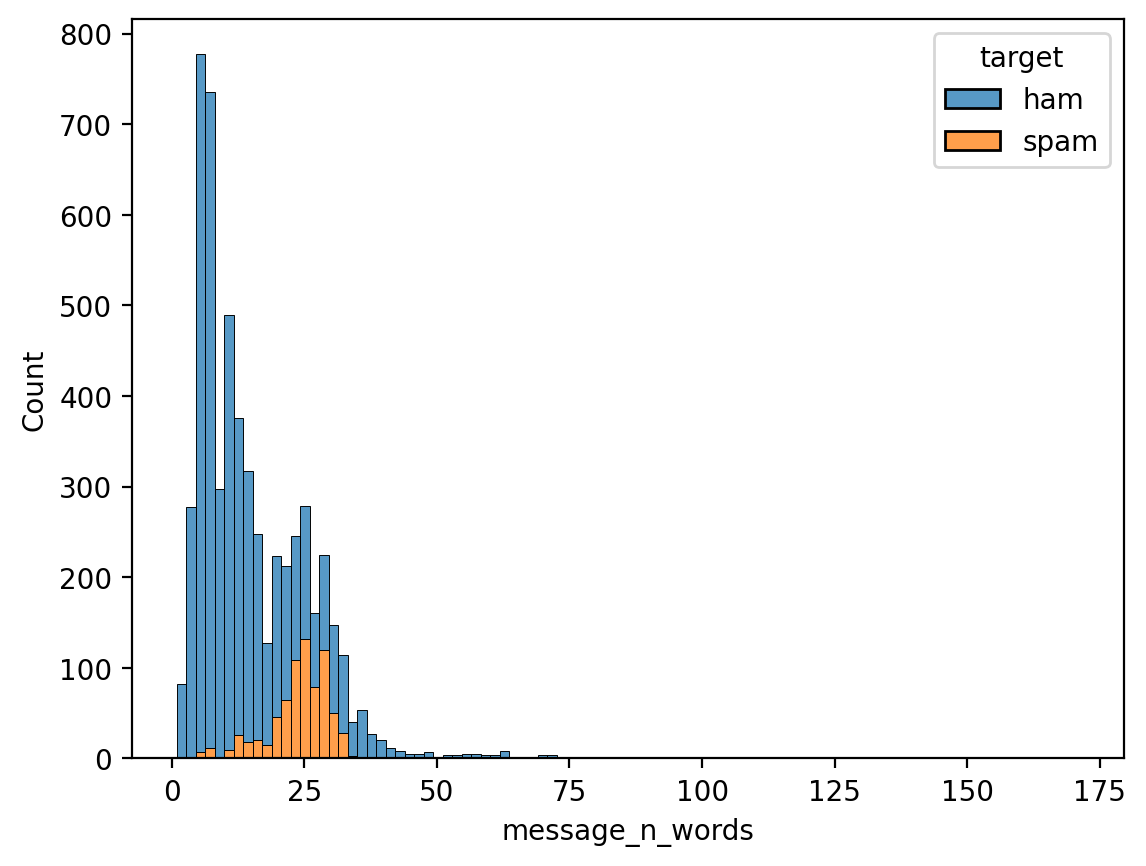

In [10]:
sns.histplot(data= df, x= 'message_n_words', hue= 'target', multiple= 'stack');

## 3- Data Pre-processing
* Cleaning 
* removing stop words
* stemming or lemma


**Stemming/ Lematization**


For grammatical reasons, documents are going to use different forms of a word, such as write, writing and writes. Additionally, there are families of derivationally related words with similar meanings. The goal of both stemming and lemmatization is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form.

* **Stemming** usually refers to a process that chops off the ends of words in the hope of achieving goal correctly most of the time and often includes the removal of derivational affixes.

* **Lemmatization** usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base and dictionary form of a word



In [11]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ernan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
stop_words = stopwords.words('english')
stemmer    = nltk.SnowballStemmer("english")

In [13]:
def clean_text(text):
    '''
        Make text lowercase, remove text in square brackets,remove links,remove punctuation
        and remove words containing numbers.
    '''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text) # remove urls
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # remove punctuation
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [14]:
def preprocess_data(text):
    text = clean_text(text)                                                     # Clean puntuation, urls, and so on
    text = ' '.join(word for word in text.split() if word not in stop_words)    # Remove stopwords
    text = ' '.join(stemmer.stem(word) for word in text.split())                # Stemm all the words in the sentence
    return text


In [15]:
df['message_clean'] = df['message'].apply(preprocess_data)
df.head()


,target,message,message_n_chars,message_n_words,lable,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,0,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,29,6,0,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,1,free entri wkli comp win fa cup final tkts may...
3,ham,U dun say so early hor... U c already then say...,49,11,0,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,0,nah dont think goe usf live around though


## 4- Vectorization

Currently, we have the messages as lists of tokens and now we need to convert each of those messages into a `vector` the models can work with.

First, we need to split data into train data and test data for applying modeling on it.

In [16]:
X = df['message_clean']
y = df['lable']

X.shape, y.shape

((5572,), (5572,))

In [17]:
# split into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,  random_state=42)
len(X_train), len(y_train), len(X_test), len(y_test)

(4457, 4457, 1115, 1115)

**CountVectorizer**

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()

X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

**Tf-idf**

`TF-IDF` **Term Frequency–Inverse Document Frequency**, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.
The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.

In [19]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer()
X_train_tfidf = tfidf.fit_transform(X_train_cv)

## 5- Modeling

### multinomial Naive Bayes
We will use `multinomial Naive Bayes`


The multinomial Naive Bayes classifier is suitable for classification with discrete features

In [20]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train_cv, y_train)

MultinomialNB()

In [21]:
# predict classes
y_pred = nb.predict(X_test_cv)
y_pred_proba = nb.predict_proba(X_test_cv)[:, 1]

In [22]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

In [23]:
p, r, f, _ = precision_recall_fscore_support(y_test, y_pred,
                                                 average='macro')
print(f'precision is  -> {round(p,2)}')
print(f'recall is -> {round(r,2)}')
print(f'f1_score is -> {round(f,2)}')

precision is  -> 0.97
recall is -> 0.95
f1_score is -> 0.96


In [24]:
# calculate the accuracy 
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy is -> {round(acc,2)}')

Accuracy is -> 0.98


In [25]:
cm = confusion_matrix(y_test, y_pred)
print('The confusion_matrix is: \n', cm);

The confusion_matrix is: 
 [[958   7]
 [ 15 135]]


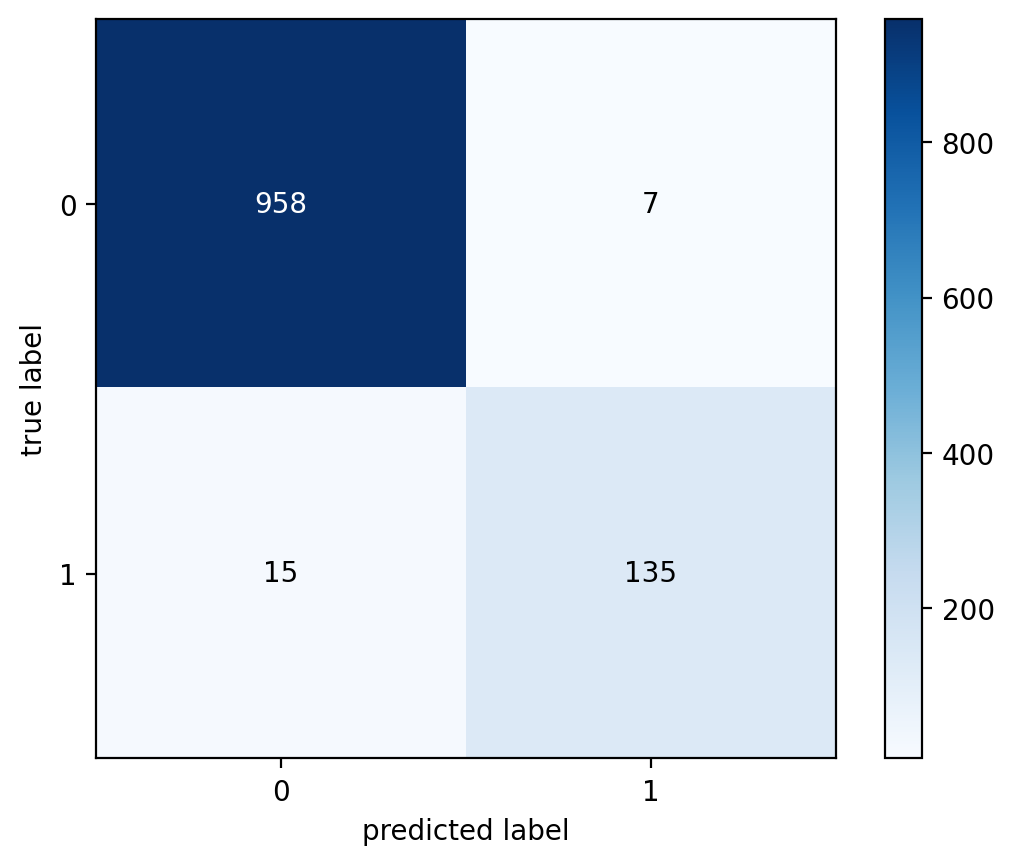

In [26]:
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat= cm, colorbar=True)
plt.show()

In [27]:
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'The roc_auc Score is -> {round(roc_auc,2)}')

The roc_auc Score is -> 0.97


### Make it by pipline

**`MultinomialNB with TF-idf`**

In [28]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

pipe = Pipeline([('bow', CountVectorizer()), 
                 ('tfidf', TfidfTransformer()),  
                 ('model', MultinomialNB())])

pipe.fit(X_train, y_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('model', MultinomialNB())])

In [29]:
y_pred = pipe.predict(X_test)

In [30]:
accuracy_score(y_test, y_pred)

0.9650224215246637

In [31]:
confusion_matrix(y_test, y_pred)

array([[965,   0],
       [ 39, 111]], dtype=int64)

### XGboost

**`XGboost with TF-idf`**

In [32]:
import xgboost as xgb

pipe = Pipeline([
                ('bow', CountVectorizer()), 
                ('tfidf', TfidfTransformer()),  
                ('model', xgb.XGBClassifier(
                    learning_rate=0.1,
                    max_depth=7,
                    n_estimators=80,
                    use_label_encoder=False,
                    eval_metric='auc'))
                ])


In [33]:
# Fit the pipeline with the data
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
# y_pred_train = pipe.predict(X_train)

# print('Train: {}'.format(accuracy_score(y_train, y_pred_train)))
print(f'Accuracy Score For Test Data: -> {round(accuracy_score(y_test, y_pred),2)}')
print(f'Confusion Matrix Score For Test Data:\n {confusion_matrix(y_test, y_pred)}')

Accuracy Score For Test Data: -> 0.97
Confusion Matrix Score For Test Data:
 [[965   0]
 [ 36 114]]


In [34]:
# calculate the accuracy 
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy is -> {round(acc,2)}')

Accuracy is -> 0.97


The **multinomial Naive Bayes** and the **XGboost** have the same accuracy score *`0.97`*

## BERT "Bidirectional Encoder Representations from Transformers"

In [35]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

import transformers
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer


In [36]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

I can also using `AutoTokenizer`

the `AutoTokenizer` class **will grab the proper tokenizer class in the library based on the checkpoint** name, and can be used directly with any checkpoint:



In [37]:
def bert_encode(input_text, max_len):
    input_ids = []
    attension_masks = []
    for text in input_text:
        output_dict = tokenizer.encode_plus(
            text, 
            add_special_tokens = True,
            truncation=True,
            max_length = max_len,
            pad_to_max_length = True,
            return_attention_mask = True
        )
        input_ids.append(output_dict['input_ids'])
        attension_masks.append(output_dict['attention_mask'])
    return np.array(input_ids), np.array(attension_masks)

In [38]:
text = df['message_clean']
target = df['lable']
train_input_ids, train_attention_masks = bert_encode(text, 60)


In [39]:
def create_model(bert_model):
    input_ids = tf.keras.Input(shape= (60,), dtype= 'int32')
    attention_masks = tf.keras.Input(shape= (60,), dtype= 'int32')
    
    output = bert_model([input_ids, attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(32, activation= 'relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)
    output = tf.keras.layers.Dense(1, activation= 'sigmoid')(output)
    
    model = tf.keras.models.Model(inputs= [input_ids, attention_masks], outputs= output)
    model.compile(Adam(lr=1e-5), loss= 'binary_crossentropy', metrics= ['accuracy'])
    return model

In [40]:
from transformers import TFBertModel
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [42]:
model = create_model(bert_model)
model.summary()

ValueError: Exception encountered when calling layer 'tf_bert_model' (type TFBertModel).

Data of type <class 'keras.src.backend.common.keras_tensor.KerasTensor'> is not allowed only (<class 'tensorflow.python.framework.tensor.Tensor'>, <class 'bool'>, <class 'int'>, <class 'transformers.utils.generic.ModelOutput'>, <class 'tuple'>, <class 'list'>, <class 'dict'>, <class 'numpy.ndarray'>) is accepted for input_ids.

Call arguments received by layer 'tf_bert_model' (type TFBertModel):
  • input_ids=['<KerasTensor shape=(None, 60), dtype=int32, sparse=None, name=keras_tensor_2>', '<KerasTensor shape=(None, 60), dtype=int32, sparse=None, name=keras_tensor_3>']
  • attention_mask=None
  • token_type_ids=None
  • position_ids=None
  • head_mask=None
  • inputs_embeds=None
  • encoder_hidden_states=None
  • encoder_attention_mask=None
  • past_key_values=None
  • use_cache=None
  • output_attentions=None
  • output_hidden_states=None
  • return_dict=None
  • training=False

In [43]:
%%time

history = model.fit(
    [train_input_ids, train_attention_masks],
    target, 
    validation_split = 0.2,
    epochs = 3,
    batch_size = 10
)

NameError: name 'model' is not defined

### BOOOM!!
The accuracy score of *BERT* reach to **`0.99`**